In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv
/kaggle/input/data-storm-6-0/train_storming_round.csv
/kaggle/input/data-storm-6-0/test_storming_round.csv


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-storm-6-0/train_storming_round.csv')
test_df = pd.read_csv('/kaggle/input/data-storm-6-0/test_storming_round.csv')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

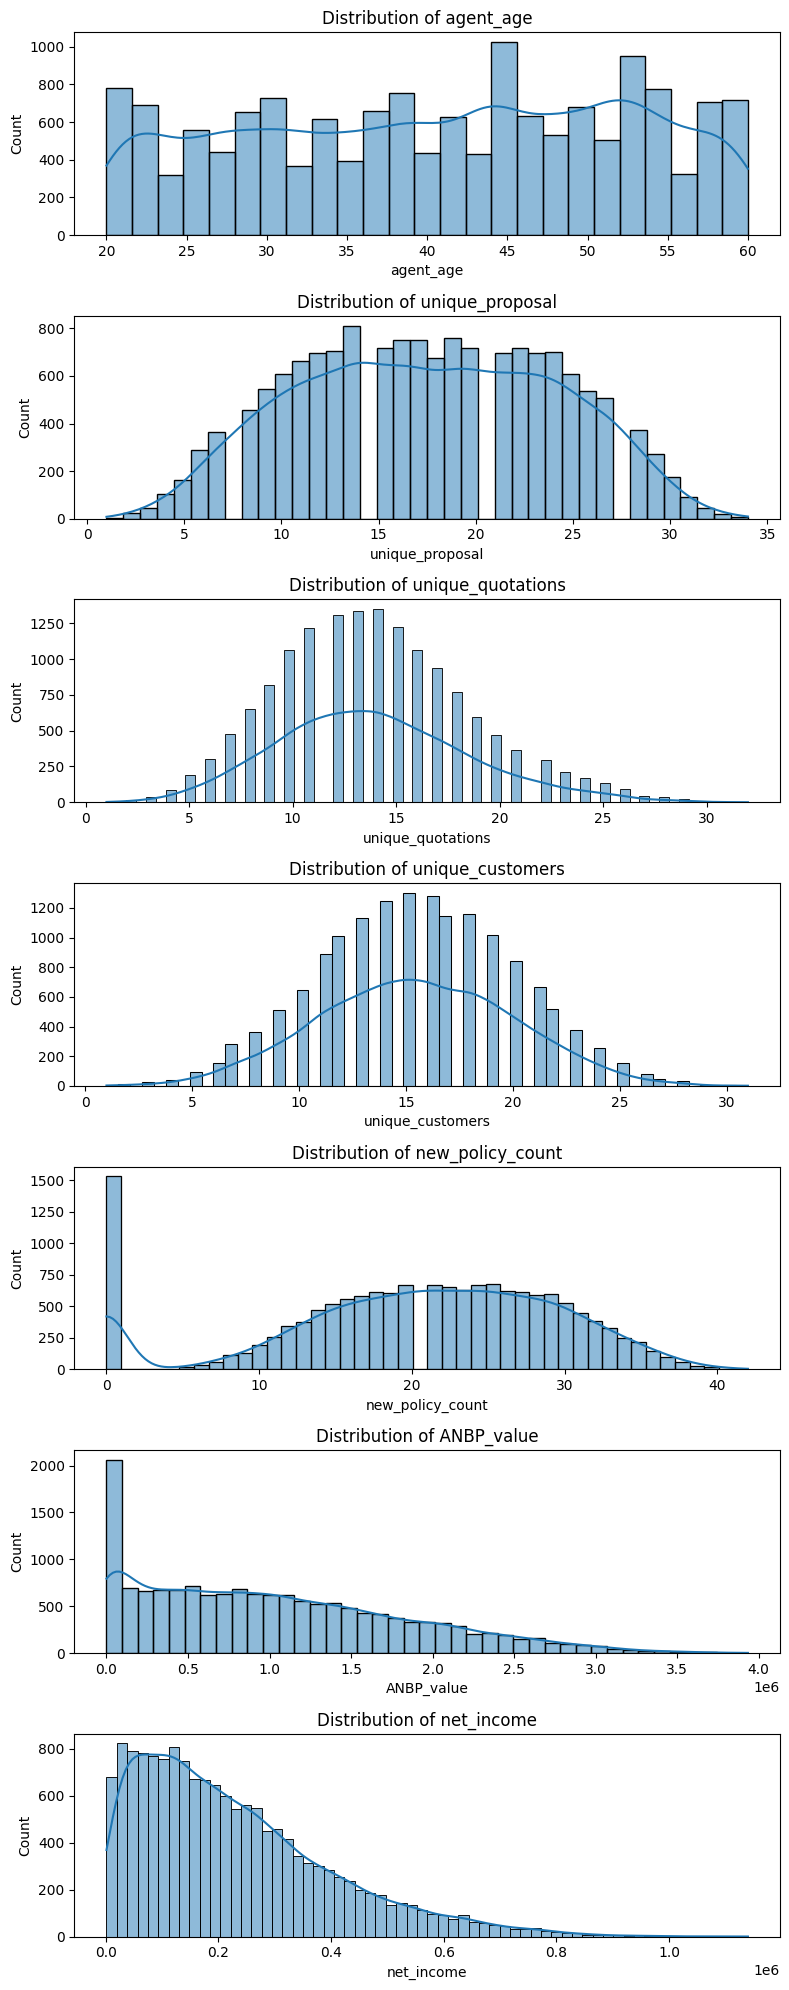

In [4]:
num_cols = ['agent_age', 'unique_proposal', 'unique_quotations', 'unique_customers', 'new_policy_count', 'ANBP_value', 'net_income']
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 20))
for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [5]:
# checking with log transformation for ANBP_value and net_income

train_df["log_ANBP_value"] = np.log1p(train_df["ANBP_value"])  # log(1 + x) handles zero values safely
test_df["log_ANBP_value"] = np.log1p(test_df["ANBP_value"])

train_df["log_net_income"] = np.log1p(train_df["net_income"])  # log(1 + x) handles zero values safely
test_df["log_net_income"] = np.log1p(test_df["net_income"])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


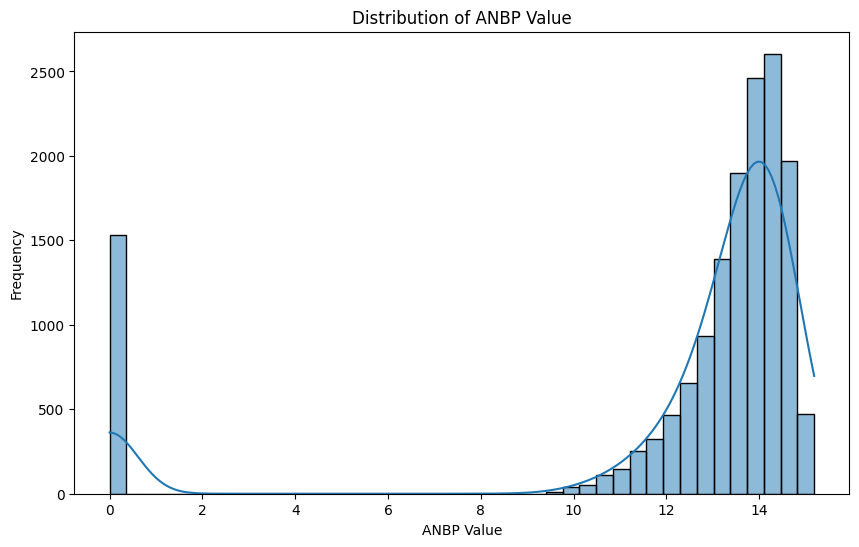

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


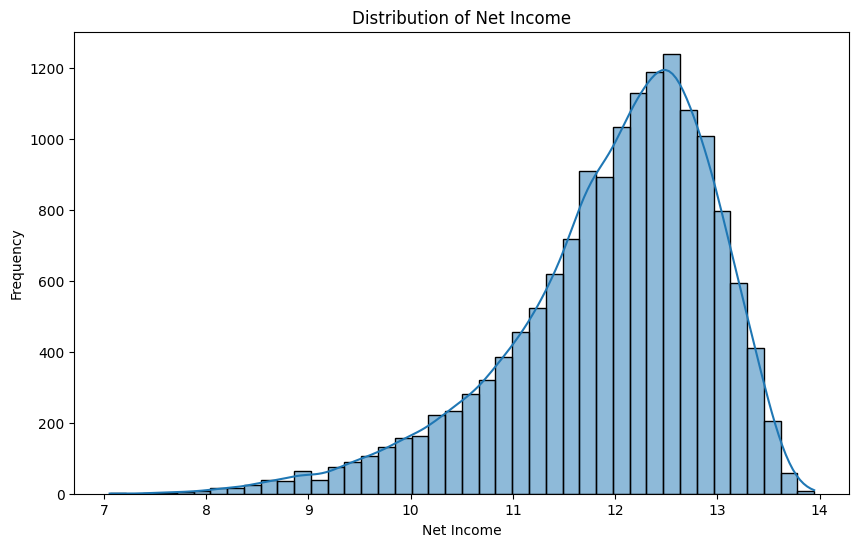

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_ANBP_value'], bins=42, kde=True)
plt.title('Distribution of ANBP Value')
plt.xlabel('ANBP Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_net_income'], bins=42, kde=True)
plt.title('Distribution of Net Income')
plt.xlabel('Net Income')
plt.ylabel('Frequency')
plt.show()

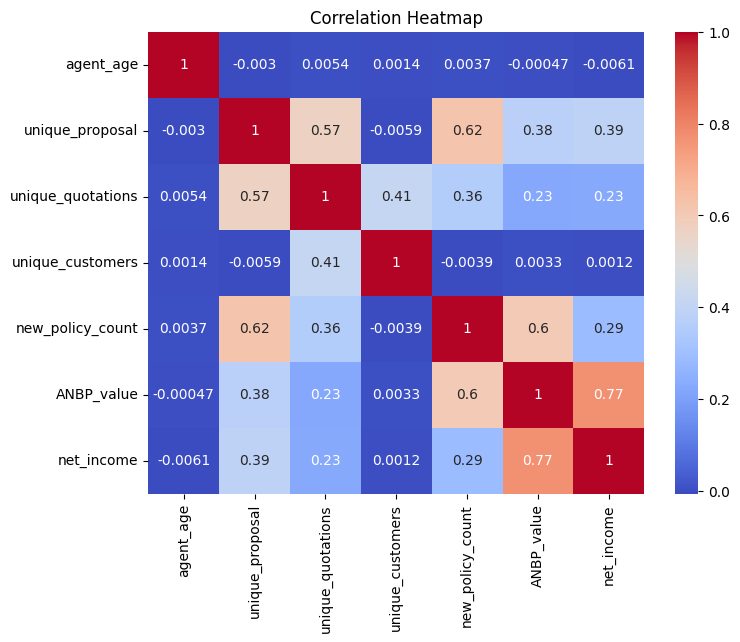

In [7]:
# Correlation heatmap

corr = train_df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


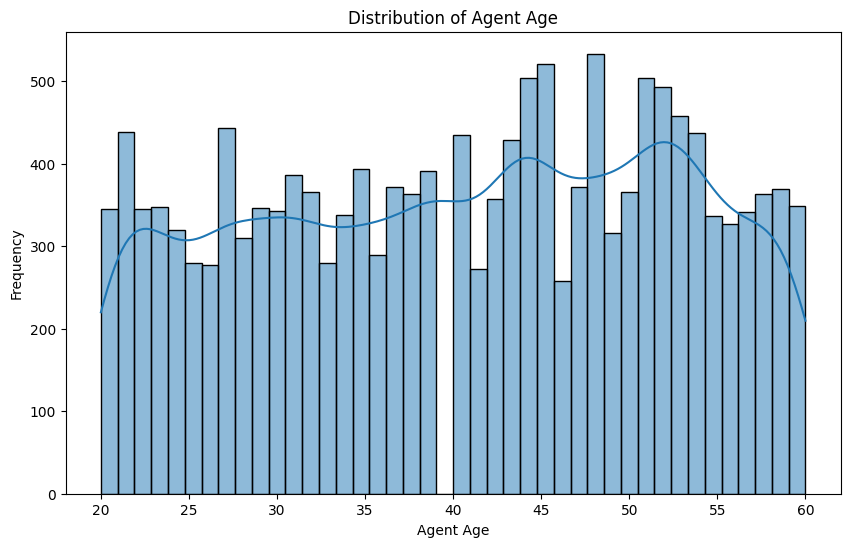

In [8]:
# prompt: plot agent age distribution

plt.figure(figsize=(10, 6))
sns.histplot(train_df['agent_age'], bins=42, kde=True)
plt.title('Distribution of Agent Age')
plt.xlabel('Agent Age')
plt.ylabel('Frequency')
plt.show()

##  Data PreProcessing

In [9]:
# Convert columns to datetime objects
for col in ['agent_join_month', 'first_policy_sold_month', 'year_month']:
    train_df[col] = pd.to_datetime(train_df[col], format='%m/%d/%Y')
    test_df[col] = pd.to_datetime(test_df[col], format='%m/%d/%Y')

In [10]:
# there are some agents with agent_join_month < first_policy_sold_month
# example: 
# row_id	 agent_code	  agent_join_month	first_policy_sold_month	
# 12704    |  e523a957  |   2024-05-01     |     2024-04-01

inconsistent = train_df[train_df["agent_join_month"] > train_df["first_policy_sold_month"]]
print(f"Inconsistent records: {len(inconsistent)}")

Inconsistent records: 115


In [11]:
# option1: swapping those columns for inconsistent rows, assuming there can be a mistake when entering data

for index in inconsistent.index:
    train_df.loc[index, 'agent_join_month'], train_df.loc[index, 'first_policy_sold_month'] = \
        train_df.loc[index, 'first_policy_sold_month'], train_df.loc[index, 'agent_join_month']

In [ ]:
# options2: Drop those inconsistent records
# reason it is appox ~0.75% data of whole dataset
train_df = train_df[train_df["agent_join_month"] <= train_df["first_policy_sold_month"]].copy()
train_df.shape

In [12]:
# making next month NILL column as the target

train_df = train_df.sort_values(by=["agent_code", "year_month"])  # sort chronologically per agent

# Shift the policy count backward per agent
train_df["target"] = train_df.groupby("agent_code")["new_policy_count"].shift(-1)

train_df["target"] = (train_df["target"] > 0).astype(int)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [13]:
def add_age_group_feature(df):
    bins = [0, 19, 39, 59, np.inf]
    labels = ["Teen", "YoungAdult", "MiddleAge", "Senior"]
    df["agent_age_group"] = pd.cut(df["agent_age"], bins=bins, labels=labels, right=True)

    df["agent_age_group_encoded"] = df["agent_age_group"].map({
        "Teen": 0,
        "YoungAdult": 1,
        "MiddleAge": 2,
        "Senior": 3
    }).astype(int)

    df.drop(columns=[
        'agent_age'
    ], inplace=True)

    return df

train_df = add_age_group_feature(train_df)
test_df = add_age_group_feature(test_df)

In [14]:
train_df

,row_id,agent_code,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,...,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,log_ANBP_value,log_net_income,target,agent_age_group,agent_age_group_encoded
8,9,003c1999,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,0,...,0,0,327407,5,0,0.000000,12.698962,1,YoungAdult,1
958,959,003c1999,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,0,...,31,2408297,408662,57,217,14.694431,12.920646,1,YoungAdult,1
1761,1762,003c1999,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,2,...,27,1901097,287226,20,243,14.457942,12.568028,1,YoungAdult,1
2577,2578,003c1999,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,3,...,22,1635788,381203,60,176,14.307636,12.851090,1,YoungAdult,1
2708,2709,003c1999,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,4,...,20,1876640,471548,0,180,14.444994,13.063778,0,YoungAdult,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10976,10977,fffb525d,2020-03-01,2023-11-01,2024-04-01,2,6,7,17,1,...,25,557100,100780,57,75,13.230502,11.520705,1,YoungAdult,1
12008,12009,fffb525d,2020-03-01,2023-11-01,2024-05-01,0,6,12,23,0,...,29,1367553,316643,0,29,14.128534,12.665533,0,YoungAdult,1
12950,12951,fffb525d,2020-03-01,2023-11-01,2024-06-01,2,6,5,14,1,...,0,0,118609,54,184,0.000000,11.683596,1,YoungAdult,1
13905,13906,fffb525d,2020-03-01,2023-11-01,2024-07-01,1,1,20,27,0,...,33,117810,24775,33,264,11.676837,10.117631,1,YoungAdult,1


##  Feature Engineering


In [15]:
def add_engineered_features(df):
    # Ratio Features (safe division)
    df["proposal_to_customer_ratio"] = df["unique_proposal"] / (df["unique_customers"] + 1e-3)
    df["quotation_to_customer_ratio"] = df["unique_quotations"] / (df["unique_customers"] + 1e-3)
    df["quotation_to_proposal_ratio"] = df["unique_quotations"] / (df["unique_proposal"] + 1e-3)

    # Disjoint Weekly Activity Features (based on provided bins)
    df["activity_week_1"] = df["unique_proposals_last_7_days"] + df["unique_customers_last_7_days"]
    df["activity_week_2"] = df["unique_proposals_last_15_days"] + df["unique_customers_last_15_days"]
    df["activity_week_3"] = df["unique_proposals_last_21_days"] + df["unique_customers_last_21_days"]

    # Cumulative Activity Windows
    df["activity_last_15_days"] = df["activity_week_1"] + df["activity_week_2"]
    df["activity_last_21_days"] = df["activity_last_15_days"] + df["activity_week_3"]

    # Rolling engagement ratios
    df["recent_proposal_ratio"] = df["unique_proposals_last_7_days"] / (df["unique_proposal"] + 1e-3)
    df["recent_customer_ratio"] = df["unique_customers_last_7_days"] / (df["unique_customers"] + 1e-3)

    # Time Since Agent Joined & First Policy Sold
    df["months_since_join"] = abs((df["year_month"] - df["agent_join_month"]).dt.days // 30)
    df["first_policy_delay_month"] = (df["first_policy_sold_month"] - df["agent_join_month"]).dt.days // 30
    # df["first_policy_delay_month"] = df["first_policy_delay_month"].clip(lower=0)

    # Binary Flags
    # df["is_new_agent"] = (df["months_since_join"] < 3).astype(int)

    # Temporal Features
    df["month"] = df["year_month"].dt.month
    # df["year"] = df["year_month"].dt.year

    # Optional Log-Transformed Features (add only after visual inspection)
    # df["log_ANBP_value"] = np.log1p(df["ANBP_value"])
    df["log_net_income"] = np.log1p(df["net_income"])
    # df["log_policy_holders"] = np.log1p(df["number_of_policy_holders"])
    # df["log_cash_payment_policies"] = np.log1p(df["number_of_cash_payment_policies"])

    # Drop original skewed versions if you're using log-transformed versions
    df.drop(columns=[
        "ANBP_value", "net_income", "number_of_policy_holders", "number_of_cash_payment_policies", 'row_id', 'year_month', 'agent_join_month', 'first_policy_sold_month', 'agent_code', 'new_policy_count', 'activity_week_1'
        , 'activity_week_3'
    ], inplace=True)

    return df

In [16]:
train_filtered_df = add_engineered_features(train_df)
test_filtered_df = add_engineered_features(test_df)

In [17]:
# Select only the required columns from both DataFrames
selected_columns = ["log_net_income", "first_policy_delay_month", "quotation_to_customer_ratio", "months_since_join", 
                    "proposal_to_customer_ratio", "recent_customer_ratio", "recent_proposal_ratio", "activity_last_21_days", 
                    "quotation_to_proposal_ratio", "agent_age_group_encoded", "target"]

train_filtered_df = train_filtered_df[selected_columns]
test_filtered_df = test_filtered_df[selected_columns[:-1]] # Exclude 'target' from test set

In [22]:
print(train_filtered_df.shape)
print(test_filtered_df.shape)

(15308, 11)
(914, 10)


## Model Train  

### Why We Selected LightGBM for This Problem

We selected LightGBM (Light Gradient Boosting Machine) as our primary model for predicting NILL agents due to its high efficiency, strong performance on structured data, and ability to handle class imbalance.

**Key Reasons:**

- **Excellent Performance on Tabular Data**  
  LightGBM is specifically designed for structured datasets and consistently achieves state-of-the-art results in classification tasks like this one.

- **Handles Class Imbalance Natively**  
  The dataset has far more active agents than NILL agents. LightGBM supports `is_unbalance` and `scale_pos_weight` parameters to adjust for this automatically.

- **Fast and Memory-Efficient**  
  It uses histogram-based training, which makes it significantly faster than traditional gradient boosting — ideal for mid-sized datasets with many features.

- **Learns Non-linear Relationships Automatically**  
  With many time-based and behavioral features, LightGBM can discover complex feature interactions without heavy manual effort.

- **Interpretable and Well-Supported**  
  Feature importance and SHAP integration make it easy to interpret results and understand what drives predictions.

Overall, LightGBM offers a great balance of speed, accuracy, and flexibility — making it an ideal choice for this predictive modeling task.


In [23]:
X = train_filtered_df.drop(columns=["target"])
y = train_filtered_df["target"]

X_test_final = test_filtered_df

##### *Hyperparameter tuning*

In [ ]:
pip install optuna

In [24]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [81]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "is_unbalance": True,
        "verbosity": -1,
        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)  # silences logs
            ],
        )

        y_pred = model.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    return sum(aucs) / len(aucs)

In [82]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-09 03:12:05,951] A new study created in memory with name: no-name-6b3c9dd7-5bda-4f1e-94f2-f51627be94ef


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.608947
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.62004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.605359
Training until validation scores don't improve for 50 rounds


[I 2025-05-09 03:12:07,254] Trial 0 finished with value: 0.6105531675484303 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02339079384844008, 'num_leaves': 101, 'max_depth': 4, 'feature_fraction': 0.8704749707230912, 'bagging_fraction': 0.8143272480576427, 'bagging_freq': 2, 'min_data_in_leaf': 28, 'lambda_l1': 1.0400359651926157, 'lambda_l2': 3.4024670091931943}. Best is trial 0 with value: 0.6105531675484303.


Early stopping, best iteration is:
[247]	valid_0's auc: 0.592231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.626189


Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
[W 2025-05-09 03:13:11,836] Trial 1 failed with parameters: {'boosting_type': 'dart', 'learning_rate': 0.019293335683936545, 'num_leaves': 63, 'max_depth': 10, 'feature_fraction': 0.6063905895003809, 'bagging_fraction': 0.8938718839464179, 'bagging_freq': 3, 'min_data_in_leaf': 33, 'lambda_l1': 2.4797170598601004, 'lambda_l2': 0.28752832419653873} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_31/3928990800.py", line 30, in objective
    model = lgb.train(
            ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py", line 307, in train
    booster.upda

KeyboardInterrupt: 

In [25]:
print("Best AUC:", study.best_value)
print("Best Parameters:", study.best_params)

NameError: name 'study' is not defined

In [26]:
best_params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.02339079384844008, 
    'num_leaves': 101, 
    'max_depth': 4, 
    'feature_fraction': 0.8704749707230912, 
    'bagging_fraction': 0.8143272480576427, 
    'bagging_freq': 2, 
    'min_data_in_leaf': 28, 
    'lambda_l1': 1.0400359651926157, 
    'lambda_l2': 3.4024670091931943,
    "is_unbalance": True, 
    "verbosity": -1, 
    "random_state": 42
}

# best_params = { 
#     'boosting_type': 'gbdt', 
#     'learning_rate': 0.06023770433755322, 
#     'num_leaves': 127, 
#     'max_depth': 7, 
#     'feature_fraction': 0.8983652411940216, 
#     'bagging_fraction': 0.9416501618853614, 
#     'bagging_freq': 2, 
#     'min_data_in_leaf': 40, 
#     'lambda_l1': 3.0587411228683608, 
#     'lambda_l2': 2.271712913386732, 
#     "is_unbalance": True, 
#     "verbosity": -1, 
#     "random_state": 42
# }

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)  # silences logs
        ],
    )

    y_val_pred_proba = model.predict(X_val)
    auc = roc_auc_score(y_val, y_val_pred_proba)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)
    models.append(model)


Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's l2: 0.125814
AUC: 0.6115

Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 0.124937
AUC: 0.6273

Fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's l2: 0.126347
AUC: 0.6095

Fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l2: 0.12633
AUC: 0.5948

Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's l2: 0.125318
AUC: 0.6196


In [28]:
print(f"\nMean AUC across folds: {np.mean(auc_scores):.4f}")


Mean AUC across folds: 0.6126


## Model Evaluation

In [29]:
from sklearn.metrics import precision_recall_curve, f1_score

# predicted probabilities on validation set
probs = model.predict(X_val)

# actual labels
y_true = y_val

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, probs)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Get the threshold with highest F1 score
best_index = f1_scores.argmax()
best_threshold = thresholds[best_index]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_index]:.3f}, Recall: {recall[best_index]:.3f}, F1: {f1_scores[best_index]:.3f}")

Best Threshold: 0.507
Precision: 0.850, Recall: 0.998, F1: 0.918


In [32]:
test_probs = model.predict(X_test_final)
test_preds = (test_probs >= 0.35).astype(int)

(array([  3.,   3.,   3.,   4.,   6.,   5.,   4.,   5.,   4.,   7.,   8.,
          3.,   1.,   2.,   0.,   2.,   0.,   0.,   0.,   1.,   3.,   1.,
          3.,   1.,   3.,   9.,   6.,  13.,  17.,  27.,  38.,  63.,  88.,
         87., 105., 116.,  98.,  90.,  61.,  18.,   5.,   1.]),
 array([0.23128226, 0.24811091, 0.26493955, 0.2817682 , 0.29859684,
        0.31542548, 0.33225413, 0.34908277, 0.36591142, 0.38274006,
        0.39956871, 0.41639735, 0.43322599, 0.45005464, 0.46688328,
        0.48371193, 0.50054057, 0.51736922, 0.53419786, 0.5510265 ,
        0.56785515, 0.58468379, 0.60151244, 0.61834108, 0.63516973,
        0.65199837, 0.66882702, 0.68565566, 0.7024843 , 0.71931295,
        0.73614159, 0.75297024, 0.76979888, 0.78662753, 0.80345617,
        0.82028481, 0.83711346, 0.8539421 , 0.87077075, 0.88759939,
        0.90442804, 0.92125668, 0.93808532]),
 <BarContainer object of 42 artists>)

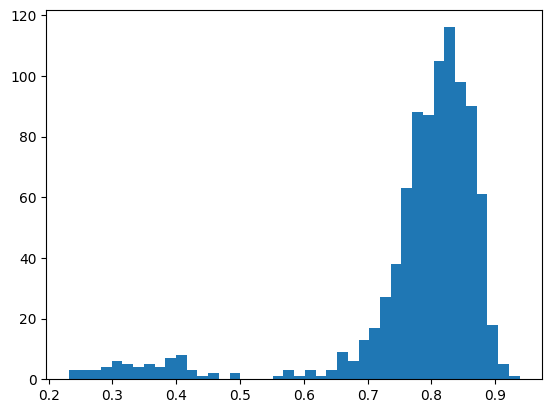

In [31]:
plt.hist(test_probs, bins=42)

### Test Prediction  

In [34]:
# Reload original test file just to get Row ID
row_id = pd.Series(range(1, 915))

# Create submission DataFrame
submission = pd.DataFrame({
    "row_id": row_id,
    "target": test_preds
})

# Save to CSV
submission.to_csv("submission_final(test-17).csv", index=False)

## Feature Importance

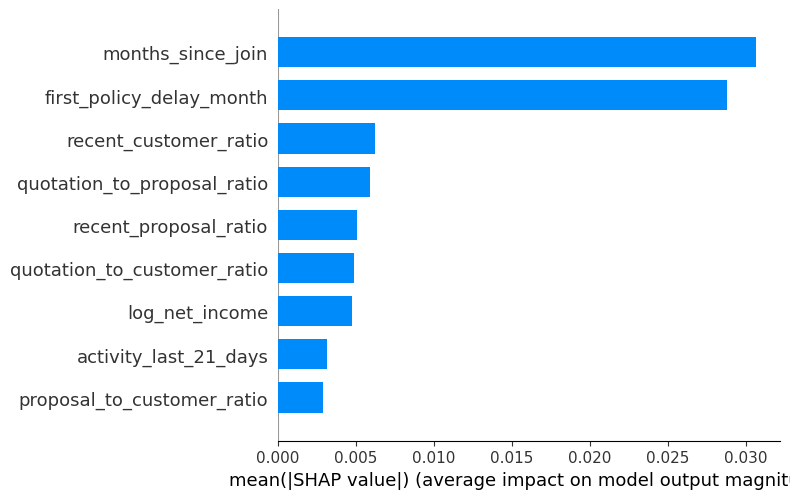

In [80]:
import shap

explainer = shap.TreeExplainer(models[0])
X_sample = X_val.sample(n=500, random_state=42)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")